In [1]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

In [2]:
from langchain_openai import ChatOpenAI

subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
trivia_prompt = """Tell an interesting fact about {subject}. Make it fun and engaging."""
best_trivia_prompt = """Below are a bunch of interesting facts about {topic}. Select the one which is the most fun and engaging! Return the ID of the best one, starting 0 as the ID for the first fact. Facts: \n\n  {trivia}"""

model = ChatOpenAI(model="gpt-4.1-mini", temperature=0) 

In [3]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestTrivia(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    trivia: Annotated[list, operator.add]
    best_selected_trivia: str

In [4]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    
    return {"subjects": response.subjects}

In [5]:
from langgraph.types import Send

def continue_to_trivia(state: OverallState):
    return [Send("generate_trivia", {"subject": s}) for s in state["subjects"]]

In [6]:
class TriviaState(TypedDict):
    subject: str

class Trivia(BaseModel):
    trivia: str

def generate_trivia(state: TriviaState):
    prompt = trivia_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Trivia).invoke(prompt)

    return {"trivia": [response.trivia]}

In [7]:
def best_trivia(state: OverallState):
    trivia = "\n\n".join(state["trivia"])
    prompt = best_trivia_prompt.format(topic=state["topic"], trivia=trivia)
    response = model.with_structured_output(BestTrivia).invoke(prompt)

    return {"best_selected_trivia": state["trivia"][response.id]}

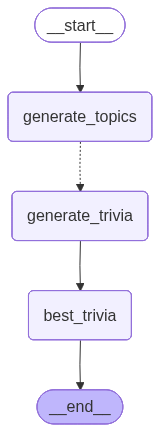

In [8]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_trivia", generate_trivia)
graph.add_node("best_trivia", best_trivia)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_trivia, ["generate_trivia"])
graph.add_edge("generate_trivia", "best_trivia")
graph.add_edge("best_trivia", END)

app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [9]:
for s in app.stream({"topic": "Vodka"}):
    print(s)

{'generate_topics': {'subjects': ['History of Vodka', 'Vodka Production Process', 'Popular Vodka Cocktails']}}
{'generate_trivia': {'trivia': ['Did you know that vodka was once used as a form of currency in Russia? In the 18th century, Russian soldiers were sometimes paid with vodka rations instead of money, making it both a drink and a valuable commodity!']}}
{'generate_trivia': {'trivia': ["Did you know that vodka can be made from almost anything that ferments? While it's commonly made from grains or potatoes, some adventurous distillers have crafted vodka from things like grapes, milk, and even honey! This versatility makes vodka production a fascinating blend of science and creativity."]}}
{'generate_trivia': {'trivia': ['Did you know that the classic Vodka Martini, famously ordered "shaken, not stirred" by James Bond, actually became popular because vodka\'s neutral flavor mixes so well with other ingredients, making it the perfect spy\'s drink for a smooth yet powerful kick!']}}
